### General 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as tm

# Use scipy package solve_ivp to integrate the chemical network
from scipy.integrate import solve_ivp

In [2]:
def eqnh(r):
    """ Print a rate eqn header """
    nr = len(r)
    s = '  Eqn:      sum = '
    for j in range(nr):
        space = '    ' if j<10 else '   '
        s += space+'r[{:d}]'.format(j)
    print(s)
    
def eqnp(label,select,dn,r):
    """ Print rates, with dominant ones in red """
    nr = len(r)
    red = '\x1b[31m'
    black = '\x1b[0m'
    rmax = 0.0
    for j in range(nr):
        if select[j] != 0:
            ra = np.abs(r[j])
            if ra > rmax:
                rmax = ra
    s = '{:>5}: {:8.1e} = '.format(label,dn[i[label]])
    for j in range(nr):
        ra = np.abs(r[j])
        color = red if ra > 0.1*rmax else black          
        if select[j]==0:
            s += '        '
        elif select[j]>0:
            s += '{}+{:7.1e}{}'.format(color,r[j],black)
        else:
            s += '{}-{:7.1e}{}'.format(color,r[j],black)
    print(s)

# for convenience, a small function to print out the network
def rpr(n):
    j = 0
    print('with the reaction rates:')
    for k in rate_coefficients().keys():
        s = 'r[{}]'.format(j)
        print('{:>22}: {}'.format(s,k))
        j += 1

#### $\bf{Task\ 1,\ Task\ 2,\ Task\ 3}$

In [3]:
i = {'O+':0,'H2':1 ,'OH+':2, 'H':3, 'H2O+':4 , 'H3O+':5, 'E':6, 'H2O':7 , 'OH':8, 'O':9}
N_species = len(i)

In [4]:
number_density = np.zeros(N_species)
n_H2 = 1e7
number_density[:      ] = 1e-40
number_density[i['H2']] = n_H2
number_density[i['O' ]] = 1e-3*n_H2
Tgas = 50.0                             # Temperature [K], passed as global value
ionizing_cosmic_ray_flux = 1.3e-17      # Ionisation rate per atom [1/s]

In [5]:
def rate_coefficients():
    invsqrt = 1e0/np.sqrt(Tgas/3e2)
    k = {}
    k['O+   + H2 -> OH+  + H' ] = 1.6e-9
    k['OH+  + H2 -> H2O+ + H' ] = 1.1e-9
    k['H2O+ + H2 -> H3O+ + H' ] = 6.1e-10 
    k['H3O+ + E  -> H2O  + H' ] = 1.1e-7*invsqrt 
    k['H2O+ + E  -> OH   + H' ] = 8.6e-8*invsqrt
    k['H2O+ + E  -> O    + H2'] = 3.9e-8*invsqrt
    k['OH+  + E  -> O    + H' ] = 6.3e-9*(Tgas/3e2)**(-.48)
    k['O    + CR -> O+   + E' ] = 2.8e0*ionizing_cosmic_ray_flux
    return k
k=rate_coefficients()
k

{'O+   + H2 -> OH+  + H': 1.6e-09,
 'OH+  + H2 -> H2O+ + H': 1.1e-09,
 'H2O+ + H2 -> H3O+ + H': 6.1e-10,
 'H3O+ + E  -> H2O  + H': 2.694438717061496e-07,
 'H2O+ + E  -> OH   + H': 2.106561178793533e-07,
 'H2O+ + E  -> O    + H2': 9.553009996854394e-08,
 'OH+  + E  -> O    + H': 1.4888575570590416e-08,
 'O    + CR -> O+   + E': 3.64e-17}

In [6]:
def reaction_rates(n):
    k = rate_coefficients()
    return  [k['O+   + H2 -> OH+  + H' ] * n[i['O+'  ]] * n[i['H2']], # 0
             k['OH+  + H2 -> H2O+ + H' ] * n[i['OH+' ]] * n[i['H2']], # 1
             k['H2O+ + H2 -> H3O+ + H' ] * n[i['H2O+']] * n[i['H2']], # 2
             k['H3O+ + E  -> H2O  + H' ] * n[i['H3O+']] * n[i['E' ]], # 3
             k['H2O+ + E  -> OH   + H' ] * n[i['H2O+']] * n[i['E' ]], # 4
             k['H2O+ + E  -> O    + H2'] * n[i['H2O+']] * n[i['E' ]], # 5
             k['OH+  + E  -> O    + H' ] * n[i['OH+' ]] * n[i['E' ]], # 6
             k['O    + CR -> O+   + E' ] * n[i['O'   ]]]              # 7
reaction_rates(number_density)

[1.6e-42,
 1.0999999999999997e-42,
 6.0999999999999996e-43,
 2.694438717061495e-87,
 2.1065611787935326e-87,
 9.553009996854392e-88,
 1.4888575570590414e-88,
 3.6399999999999996e-13]

In [7]:
def differential_equations(t,n):
    r = reaction_rates(n)
    dn = np.zeros(N_species)
    dn[i['O+'  ]] = -r[0]                              +r[7]
    dn[i['H2'  ]] = -r[0]-r[1]-r[2]          +r[5]
    dn[i['OH+' ]] = +r[0]-r[1]                    -r[6]
    dn[i['H'   ]] = +r[0]+r[1]+r[2]+r[3]+r[4]     +r[6]
    dn[i['H2O+']] =      +r[1]-r[2]     -r[4]-r[5]
    dn[i['H3O+']] =           +r[2]-r[3]
    dn[i['E'   ]] =                -r[3]-r[4]-r[5]-r[6]+r[7]
    dn[i['H2O' ]] =                +r[3]
    dn[i['OH'  ]] =                     +r[4]
    dn[i['O'   ]] =                          +r[5]+r[6]-r[7]
    return dn
differential_equations(0.0, number_density)

array([ 3.64000000e-13, -3.31000000e-42,  5.00000000e-43,  3.31000000e-42,
        4.90000000e-43,  6.10000000e-43,  3.64000000e-13,  2.69443872e-87,
        2.10656118e-87, -3.64000000e-13])

In [8]:
def solution(diff_eqs, yrs=1e7, max_step=1e6, method='LSODA', rtol=1e-6, atol=1e-40):
    spy = 365e0*24e0*3600e0        # seconds per year
    time_step = np.copy(spy)       # initial time-step (s)
    time_end  = yrs*spy            # end of simulation (s)
    n = number_density

    start = tm.time()

    # time_grid is a geometricly increasing series with a max spacing of "max_step" yrs
    time_grid = []
    time      = 0.1 * time_step   # initial time output > 0 to avoid species having 1e-40 number density
    while time < time_end:
        time_grid.append(time)
        time += time_step
        time_step = min(time_step * 1.05, max_step*spy)

    time_grid = np.array(time_grid)

    # Make sure we are charge neutral. Compute electrons number density (sum over ions)
    n[i['E']] = n[i['O+']] + n[i['OH+']] + n[i['H2O+']] + n[i['H3O+']]

    # Solve the differential equations defined in "diff_eqs" over the interval "(0,time_end)"
    # with input values "n" storing the solution at times "time_grid" using the ODE solver
    # method "method" (LSODA) with relative and absolute tolerances "rtol", "atol".
    solution = solve_ivp(diff_eqs, (0, time_end), n, t_eval=time_grid, \
                         method=method, rtol=rtol, atol=atol)
    print('time used: {:.2f} sec'.format(tm.time()-start))

    # return solution times in units of yr and number densities for each time in time_grid.
    return solution.t/spy, solution.y

yr,n = solution(differential_equations)

time used: 0.04 sec


time used: 0.04 sec


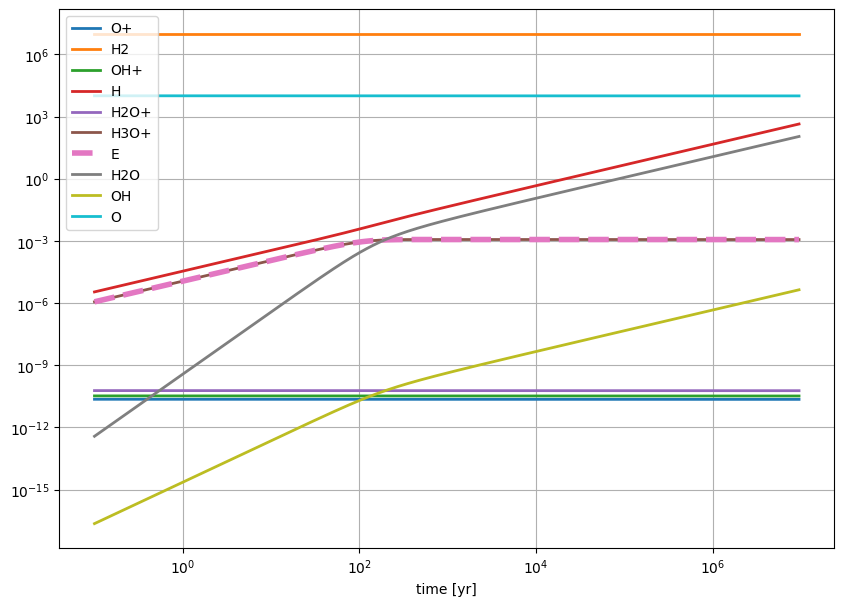

In [9]:
def plot(result,first=0,last=N_species,linewidth=2,mark=None):
    yr = result[0]
    n = result[1]
    names = list(i.keys())
    plt.figure(figsize=(10,7))
    plt.grid()
    #plt.ylim(ymin=10**2,ymax=10**5)
    for j in range(first,last):
        if names[j]=='E':
            plt.loglog(yr,n[j],'--',label=names[j],linewidth=linewidth*2)
        elif names[j]==mark:
            plt.loglog(yr,n[j],'-+',label=names[j],linewidth=linewidth)
        else:
            plt.loglog(yr,n[j],label=names[j],linewidth=linewidth)
    plt.xlabel('time [yr]')
    plt.legend();

# set cosmic ray flux and recalculate network
ionizing_cosmic_ray_flux = 1.3e-17
result = solution(differential_equations)
plot(result)

#### ${\bf Task\ 4}$

In [10]:
ii = {'O+':0,'H2':1 ,'OH+':2, 'H':3, 'H2O+':4 , 'H3O+':5, 'E':6, 'H2O':7 , 'OH':8, 'O':9,'CO':10 ,'C':11,'C+':12, 'CH2+':13 , 'CH2':14, 'H+':15}
N_species_ii=len(ii)

In [11]:
number_density_ii = np.zeros(N_species_ii)
n_H2 = 1e7
Tgas = 50
number_density_ii[:      ] = 1e-40
number_density_ii[ii['H2']] = n_H2
number_density_ii[ii['C' ]] = n_H2*1e-4
number_density_ii[ii['O' ]] = n_H2*2e-4
ionizing_cosmic_ray_flux = 1.3e-17      # Ionisation rate per atom [1/s]


In [12]:
def rate_coefficients():
    invsqrt = 1e0/np.sqrt(Tgas/3e2)
    tau_UV=0.5 #1 or 2 e-11, 3 or 4 e-12, 5 or 6 e-13
    k = {}
    k['O+   + H2 -> OH+  + H' ] = 1.6e-9
    k['OH+  + H2 -> H2O+ + H' ] = 1.1e-9
    k['H2O+ + H2 -> H3O+ + H' ] = 6.1e-10 
    k['H3O+ + E  -> H2O  + H' ] = 1.1e-7*invsqrt 
    k['H2O+ + E  -> OH   + H' ] = 8.6e-8*invsqrt
    k['H2O+ + E  -> O    + H2'] = 3.9e-8*invsqrt
    k['OH+  + E  -> O    + H' ] = 6.3e-9*(Tgas/3e2)**(-.48)
    k['O    + CR -> O+   + E' ] = 2.8e0*ionizing_cosmic_ray_flux
    k['CO   + hv -> C    + O' ] = 1e-10*np.exp(-tau_UV)
    k['C    + hv -> C+   + E' ] = 1e-10*np.exp(-tau_UV)
    k['C+   + H2 -> CH2+ + hv'] = 5e-16
    k['CH2+ + E  -> CH2  + hv'] = 1.0e-8*invsqrt
    k['CH2  + hv -> C    + H2'] = 1e-10*np.exp(-tau_UV)
    k['CH2  + O  -> CO   + H2'] = 5e-10
    k['H    + CR -> H+   + E' ] = 2.8e0*ionizing_cosmic_ray_flux
    return k
k=rate_coefficients()


In [13]:
def reaction_rates_ii(n): #I don't take into account hv
    k = rate_coefficients()
    return  [k['O+   + H2 -> OH+  + H' ] * n[ii['O+'  ]] * n[ii['H2']], # 0
             k['OH+  + H2 -> H2O+ + H' ] * n[ii['OH+' ]] * n[ii['H2']], # 1
             k['H2O+ + H2 -> H3O+ + H' ] * n[ii['H2O+']] * n[ii['H2']], # 2
             k['H3O+ + E  -> H2O  + H' ] * n[ii['H3O+']] * n[ii['E' ]], # 3
             k['H2O+ + E  -> OH   + H' ] * n[ii['H2O+']] * n[ii['E' ]], # 4
             k['H2O+ + E  -> O    + H2'] * n[ii['H2O+']] * n[ii['E' ]], # 5
             k['OH+  + E  -> O    + H' ] * n[ii['OH+' ]] * n[ii['E' ]], # 6
             k['O    + CR -> O+   + E' ] * n[ii['O'   ]]             , # 7
             k['CO   + hv -> C    + O' ] * n[ii['CO' ]]              , # 8
             k['C    + hv -> C+   + E' ] * n[ii['C' ]]               , # 9
             k['C+   + H2 -> CH2+ + hv'] * n[ii['C+' ]]* n[ii['H2' ]], # 10                      
             k['CH2+ + E  -> CH2  + hv'] * n[ii['CH2+' ]]* n[ii['E' ]], # 11
             k['CH2  + hv -> C    + H2'] * n[ii['CH2' ]]             ,# 12
             k['CH2  + O  -> CO   + H2'] * n[ii['CH2' ]] * n[ii['O' ]], #13
             k['H    + CR -> H+   + E' ] * n[ii['H'   ]]]               #14
reaction_rates_ii(number_density_ii)

[1.6e-42,
 1.0999999999999997e-42,
 6.0999999999999996e-43,
 2.694438717061495e-87,
 2.1065611787935326e-87,
 9.553009996854392e-88,
 1.4888575570590414e-88,
 7.279999999999999e-14,
 6.065306597126335e-51,
 6.065306597126334e-08,
 5e-49,
 2.4494897427831775e-88,
 6.065306597126335e-51,
 1e-46,
 3.6399999999999995e-57]

In [14]:
def plot_ii(result,first=0,last=N_species_ii,linewidth=2,mark=None):
    yr = result[0]
    n = result[1]
    names = list(ii.keys())
    plt.figure(figsize=(10,10))
    plt.grid()
    #plt.ylim(ymin=10**2,ymax=10**4)
    for j in range(first,last):
        if names[j]=='E':
            plt.loglog(yr,n[j],'--',label=names[j],linewidth=linewidth*2)
        elif names[j]=='CO':
            plt.loglog(yr,n[j],'.-',label=names[j],linewidth=linewidth*2)
        elif names[j]==mark:
            plt.loglog(yr,n[j],'-+',label=names[j],linewidth=linewidth)
        else:
            plt.loglog(yr,n[j],label=names[j],linewidth=linewidth)
    plt.xlabel('time [yr]')
    plt.legend();

In [15]:
def differential_equations_ii(t,n):
    r = reaction_rates_ii(n)
    dn = np.zeros(N_species_ii)
    dn[ii['O+'  ]] = -r[0]+r[7]
    dn[ii['H2'  ]] = -r[0]-r[1]-r[2]+r[5]-r[10]+r[12]+r[13]
    dn[ii['OH+' ]] = +r[0]-r[1]-r[6]
    dn[ii['H'   ]] = +r[0]+r[1]+r[2]+r[3]+r[4]+r[6]-r[14]
    dn[ii['H2O+']] = +r[1]-r[2]-r[4]-r[5]
    dn[ii['H3O+']] = +r[2]-r[3]
    dn[ii['E'   ]] = -r[3]-r[4]-r[5]-r[6]+r[7]+r[9]-r[11]+r[14]
    dn[ii['H2O' ]] = +r[3]
    dn[ii['OH'  ]] = +r[4]
    dn[ii['O'   ]] = +r[5]+r[6]-r[7]+r[8]-r[13]
    dn[ii['CO'  ]] = +r[13]-r[8]
    dn[ii['C'   ]] = +r[8]-r[9]+r[12]
    dn[ii['C+'  ]] = +r[9]-r[10] 
    dn[ii['CH2+']] = +r[10]-r[11]
    dn[ii['CH2' ]] = +r[11]-r[12]-r[13] 
    dn[ii['H+'  ]] = +r[14]
    return dn
differential_equations_ii(0.0, number_density_ii)

array([ 7.28000000e-14, -3.30990049e-42,  5.00000000e-43,  3.31000000e-42,
        4.90000000e-43,  6.10000000e-43,  6.06531388e-08,  2.69443872e-87,
        2.10656118e-87, -7.28000000e-14,  9.99939347e-47, -6.06530660e-08,
        6.06530660e-08,  5.00000000e-49, -1.00006065e-46,  3.64000000e-57])

In [16]:
def solution_ii(diff_eqs, yrs=1e7, max_step=1e6, method='LSODA', rtol=1e-6, atol=1e-40):
    spy = 365e0*24e0*3600e0        # seconds per year
    time_step = np.copy(spy)       # initial time-step (s)
    time_end  = yrs*spy            # end of simulation (s)
    n = number_density_ii

    start = tm.time()

    # time_grid is a geometricly increasing series with a max spacing of "max_step" yrs
    time_grid = []
    time      = 0.1 * time_step   # initial time output > 0 to avoid species having 1e-40 number density
    while time < time_end:
        time_grid.append(time)
        time += time_step
        time_step = min(time_step * 1.05, max_step*spy)

    time_grid = np.array(time_grid)

    # Make sure we are charge neutral. Compute electrons number density (sum over ions)
    n[ii['E']] = n[ii['O+']] + n[ii['OH+']] + n[ii['H2O+']] + n[ii['H3O+']]+n[ii['C+']]+n[ii['CH2+']]+n[ii['H+']]

    # Solve the differential equations defined in "diff_eqs" over the interval "(0,time_end)"
    # with input values "n" storing the solution at times "time_grid" using the ODE solver
    # method "method" (LSODA) with relative and absolute tolerances "rtol", "atol".
    solution = solve_ivp(diff_eqs, (0, time_end), n, t_eval=time_grid, \
                         method=method, rtol=rtol, atol=atol)
    print('time used: {:.2f} sec'.format(tm.time()-start))

    # return solution times in units of yr and number densities for each time in time_grid.
    return solution.t/spy, solution.y

yr,n = solution_ii(differential_equations_ii)

time used: 0.12 sec


time used: 0.12 sec


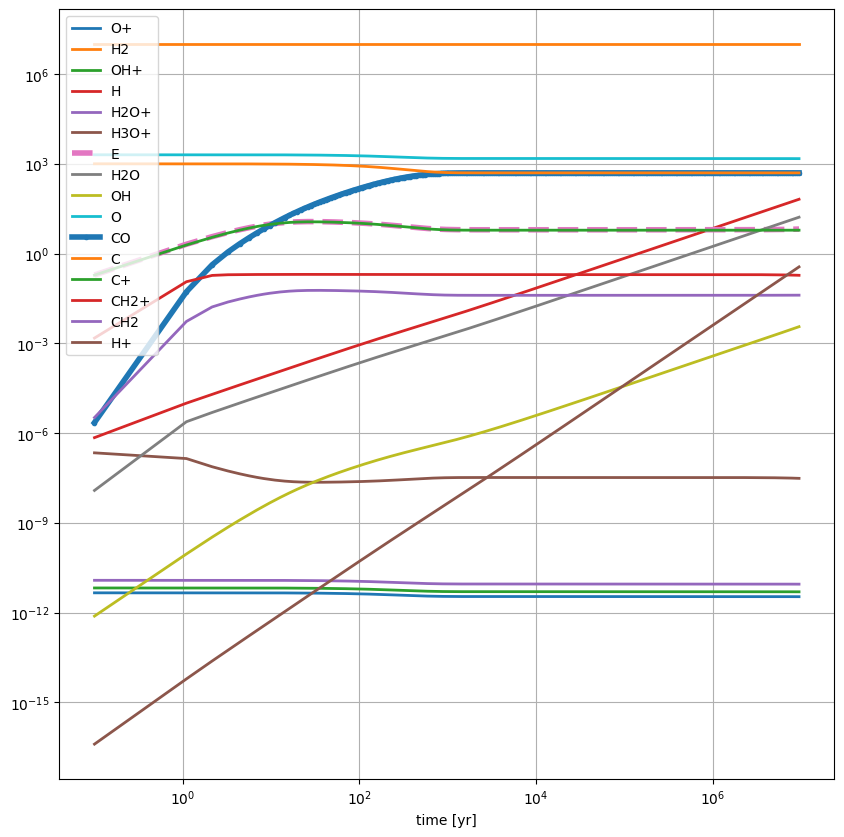

In [17]:
ionizing_cosmic_ray_flux = 1.3e-17
result = solution_ii(differential_equations_ii)
plot_ii(result)